# Le Filtrage Collaboratif (Collaborative Filtering)

### Table des matières <a id="0"></a>
- [Packages](#1)
- [Notation](#2)
- [Propos de l'ensemble de données](#3)
- [L'algorithme du filtrage collaboratif](#4)
  - [Fonction de perte](#4.1)
  - [Descente de gradient](#4.2)
- [Évaluation](#5)
- [Recommandation](#6)
  - [Comparaison entre les notes originales et les notes prévisionnelles](#6.1)
  - [Recommandation des films pour le nouvel utilisateur](#6.2)

## Packages. <a id="1"></a>

NumPy, Pandas et TensorFlow sont les packages utiles dans ce projet.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from FonctionUtile import *

## Notation. <a id="2"></a>

\begin{array}{|l|l|l|}
\hline
\text{Notation} & \text{Description} & \text{Python (le cas échéant)} \\
\hline
r(i,j) & \text{scalaire; } = 1 \text{ si l'utilisateur } j \text{ a évalué le film } i, = 0 \text{ sinon} & \\
y(i,j) & \text{scalaire; note donnée par l'utilisateur } j \text{ pour le film } i \text{ (si } r(i,j) = 1 \text{ est défini)} & \\
\mathbf{w}^{(j)} & \text{vecteur; paramètres pour l'utilisateur } j & \\
\mathbf{x}^{(i)} & \text{vecteur; caractéristiques du film } i & \\
b^{(i,j)} & \text{scalaire; paramètre de biais pour le film } i \text{ et l'utilisateur } j & \text{b}\\
b_u^{(j)} & \text{scalaire; paramètre de biais pour l'utilisateur } j &  \\
b_f^{(i)} & \text{scalaire; paramètre de biais pour le film } i  &  \\
b_u & \text{vecteur; paramètres de biais pour l'utilisateur } j & \text{b\_u} \\
b_f & \text{vecteur; paramètres de biais pour le film } i  & \text{b\_f} \\
n_u & \text{nombre d'utilisateurs} & \text{nb\_utilisateurs} \\
n_f & \text{nombre de films} & \text{nb\_films} \\
k & \text{nombre de caractéristiques} & \text{nb\_caracs} \\
\mathbf{X} & \text{matrice de vecteurs } \mathbf{x}^{(i)} & \text{X} \\
\mathbf{W} & \text{matrice de vecteurs } \mathbf{w}^{(j)} & \text{W} \\
\mathbf{B} & \text{matrice de paramètres de biais } b^{(i,j)} & \text{B} \\
\mathbf{R} & \text{matrice des éléments } r(i,j) & \text{R} \\
\mathbf{Y} & \text{matrice des éléments } y(i,j) & \text{Y} \\
\mathbf{\hat{Y}} & \text{matrice approximative de } \mathbf{Y} & \\
\hline
\end{array}

## Propos de l'ensemble de données. <a id="3"></a>

In [2]:
#importer les données
Y,R = data_ratings()
nb_caracs = 10 # Choisissez 10 car ce nombre réduit le coût tout en étant suffisamment grand pour un grand ensemble de données.
print("Matrix Y dim ", Y.shape)
print("Matrix R dim ", R.shape)
nb_films, nb_utilisateurs=Y.shape
print("Nombre de films: ", nb_films)
print("Nombre d'utilisateurs: ", nb_utilisateurs)
print("Nombre de caracteristiques: ", nb_caracs)

Matrix Y dim  (9724, 610)
Matrix R dim  (9724, 610)
Nombre de films:  9724
Nombre d'utilisateurs:  610
Nombre de caracteristiques:  10


Il est nécessaire de savoir que dans la matrice des notes $Y$, les notes vont de 0.5 à 5 par intervalles de 0.5. Toutes les cellules à 0 signifient que les clients n'ont pas encore donné de note ou n'ont pas voté.

La matrice $Y$ est une matrice creuse dans la plupart des applications, car seule une petite fraction de ses éléments est différente de zéro.

In [3]:
print("Nombre de cellules dans Y : ", nb_utilisateurs * nb_films)
print("Nombre de notes attribuées : ", R.sum())
print("Taux de notes attribuées par rapport à toutes les cellules : ", (R.sum() / (nb_utilisateurs * nb_films)) * 100, "%")

Nombre de cellules dans Y :  5931640
Nombre de notes attribuées :  100836
Taux de notes attribuées par rapport à toutes les cellules :  1.6999683055613624 %


**J'ajoute le nouvel utilisateur dans le but de lui faire [des recommandations par la suite](#rec).** <a id="new-user"></a>

In [4]:
#initialize mes notes
mes_notes = np.zeros(nb_films)

#Regarder le fichier 'movise_list.csv'
mes_notes[0]=1 # Si je ne préfére pas ce film
mes_notes[0]=5 # Si j préfére ce film

#Je crée mes listes de notes. Les notes doivent être entières
# L'index maximum correspond au (nombre total de films -1)
mes_notes[0]= 5    # Toy story (1995)
mes_notes[483]=3    # Nightmare Before Christmas, The (1993)
mes_notes[480]=2   # Terminal Velocity (1994)
mes_notes[1402]=2   # Pi (1998)
mes_notes[1400]=4   # Madeline (1998)
mes_notes[2695]=5   # Loser (2000)
mes_notes[2696]=4   # Road Trip (2000)
mes_notes[2734]=3  # Benji(1974)
mes_notes[3090]=1   # Hannibal(2001)
mes_notes[3942]=3   # Time after Time (1979)
mes_notations=     [i for i in range(len(mes_notes)) if mes_notes[i] > 0]# Stocke les indices des films que j'ai notés

In [5]:
# Ajouter un nouvel utilisateur à la matrice Y.
Y = np.c_[mes_notes, Y] #Le nouvel utilisateur ajouté occupe l'indice 0 dans la colonne des utilisateurs

# Ajouter l'indicateur de nouvel utilisateur à la matrice R
R = np.c_[(mes_notes != 0).astype(int), R]

Le nombre de films et d'utilisateurs est maintenant le suivant :

In [6]:
print("Matrix Y dim ", Y.shape)
print("Matrix R dim ", R.shape)
nb_films, nb_utilisateurs=Y.shape
print("Nombre de films: ", nb_films)
print("Nombre d'utilisateurs: ", nb_utilisateurs)

Matrix Y dim  (9724, 611)
Matrix R dim  (9724, 611)
Nombre de films:  9724
Nombre d'utilisateurs:  611


In [7]:
#Charger les données pour la fonction de pré-calcul.
Ymean, Ynorm = normalizeRatings(Y,R)
print("Matrix note moyenne dim ", Ymean.shape)
print("Matrix note normalisé dim ", Ynorm.shape)

Matrix note moyenne dim  (9724, 1)
Matrix note normalisé dim  (9724, 611)


On initialise la matrice des paramètres utilisateur $W$ et la matrice des paramètres des films $X$, où $X$ stocke les vecteurs de paramètres des utilisateurs $\mathbf{x}^{(i)}$, tandis que la matrice $W$ stocke les vecteurs de paramètres des films $\mathbf{w}^{(j)}$ afin d'entraîner le modèle. Avec cet ensemble de données, on choisit le nombre de caractéristiques $k = 10$.



In [8]:
np.random.seed(12) # for consistent results
W_initiale = np.random.normal(size=(nb_caracs, nb_utilisateurs))
X_initiale = np.random.normal(size=(nb_films, nb_caracs))
print("Matrix W dim ", W_initiale.shape)
print("Matrix X dim ", X_initiale.shape)

Matrix W dim  (10, 611)
Matrix X dim  (9724, 10)


Maintenant, nous calculons la note moyenne pour chaque film par la $i$-ème ligne de la matrice $Y$, en excluant les zéros, c'est-à-dire uniquement les films qui ont été évalués sont inclus.

On calcule les biais des utilisateurs et des films, ainsi que la moyenne de toutes les notes.

In [9]:
#Charger les données pour la fonction de pré-calcul.
utilisateur_ratings,film_ratings =  dict_evaluations()#origine 

# On utilise .copy() pour éviter que utilisateur_ratings et film_ratings 
# ne soient modifiés lorsqu'ils sont passés à la fonction update_dict_evaluations. 
# Cela permet de travailler avec des copies indépendantes des dictionnaires d'origine.
utilisateur_ratings_updated,film_ratings_updated = update_dict_evaluations(Y, utilisateur_ratings.copy(),film_ratings.copy())
print(f"La taille de dict utilisateur_ratings : {len(utilisateur_ratings)}")
print(f"La taille de dict utilisateur_ratings_updated : {len(utilisateur_ratings_updated)}")
mu,b_u,b_f = bias_param(Y, utilisateur_ratings_updated.copy(), film_ratings_updated.copy())
print(f"Total biais de l'utilisateur : {len(b_u)}")
print(f"Total biais du film: {len(b_f)}")
print(f"La moyenne de Ymean : {np.mean(Ymean)}")
print(f"La moyenne de toutes les notes : {mu}")

La taille de dict utilisateur_ratings : 610
La taille de dict utilisateur_ratings_updated : 611
Total biais de l'utilisateur : 611
Total biais du film: 9724
La moyenne de Ymean : 3.2624895815718498
La moyenne de toutes les notes : 3.501527080895623


En effet, la moyenne de $\mathbf Ymean$ (c'est-à-dire la moyenne des moyennes de chaque film) n'est pas la même que la moyenne de toutes les notes, simplement parce que dans la moyenne de toutes les notes ($\mu$), chaque évaluation est considérée comme une valeur ponctuelle, donc toutes les évaluations ont un poids égal. Dans la moyenne de Ymean, vous calculez d'abord la moyenne pour chaque film. Cela peut augmenter ou diminuer le poids des films en fonction du nombre d'évaluations que chaque film reçoit.

In [10]:
B = Biais_matrix(b_f,b_u,mu,Y) #pre-calculé la matrice de biais
print(B.shape)

(9724, 611)


## L'algorithme du filtrage collaboratif.<a id="4"></a>

### 1. fonction de perte. <a id="4.1"></a>

#### Le modèle initial

$$\begin{align}
\mathcal{L}(\mathbf{x^{(i)}}, \mathbf{w^{(j)}}, \mathbf{b_u}^{(j)},\mathbf{b_m}^{(i)})= \frac{1}{2} & \sum_{(i,j) : r(i,j) = 1}  \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b_u}^{(j)} + \mathbf{b_m}^{(i)} +\mu - y(i,j) \right)^2  + \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b_u}^{(j)})^2 + (\mathbf{b_m}^{(i)})^2 \right) }_{\text{regularization}} 
\end{align} $$

In [11]:
def FonctionPerte_Init(W,X,b_u,b_f,Y,R,lambda_,mu):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   b_u (ndarray (1, nb_utilisateur)) : vecteur des parametres de biais.
   b_f (ndarray (nb_films, 1)) : vecteur des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   R (ndarray (nb_films,nb_utilisateurs)): matrice où R(i, j) = 1 si le j-ème utilisateur a évalué le i-ème film
   lambda_ (float): paramètre de régularisation
   mu (float) : la moyenne de toutes les évaluations attribuées
 Retourne :
   L (float): valeur de perte
   """
    
   l = (tf.linalg.matmul(X, W) + b_u + b_f + mu - Y)*R
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(b_u**2)+tf.reduce_sum(b_f**2))
   return L

#### L'ajustement du modèle

$$
\mathcal{L}(\mathbf{x^{(i)}}, \mathbf{w^{(j)}}, \mathbf{b}^{(i,j)}) = \frac{1}{2} \sum_{(i,j) : r(i,j) = 1} \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b}^{(i,j)} + \mu - y(i,j) \right)^2
+ \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b}^{(i,j)})^2 \right) }_{\text{regularization}} 
$$


In [12]:
def FonctionPerte_Ajust(W,X,B,Y,R,lambda_,mu):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   B (ndarray (nb_films, nb_utilisateurs)) : matrice des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   R (ndarray (nb_films,nb_utilisateurs)): matrice où R(i, j) = 1 si le j-ème utilisateur a évalué le i-ème film
   lambda_ (float): paramètre de régularisation
   mu (float) : la moyenne de toutes les évaluations attribuées
 Retourne :
   L (float): valeur de perte
   """
   l = (tf.linalg.matmul(X, W) + B + mu - Y)*R
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(B**2))
   return L

#### Des ajustements supplémentaires du modèle: 

##### l'Approche 1:

$$\begin{align}
\mathcal{L}({\mathbf{x^{(i)}}, \mathbf{w^{(j)}}, \mathbf{b_u^{(j)}}, \mathbf{b_m^{(i)}}})= \frac{1}{2} & \sum_{(i,j) : r(i,j) = 1}  \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b_u}^{(j)} + \mathbf{b_m}^{(i)} - y_{\text{norm}}(i,j) \right)^2 + \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b_u}^{(j)})^2 + (\mathbf{b_m}^{(i)})^2 \right) }_{\text{regularization}} 
\end{align} $$

In [13]:
def FonctionPerte_Sup1(W,X,b_u,b_f,Y,R,lambda_):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   b_u (ndarray (1, nb_utilisateur)) : vecteur des parametres de biais.
   b_f (ndarray (nb_films, 1)) : vecteur des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   R (ndarray (nb_films,nb_utilisateurs)): matrice où R(i, j) = 1 si le j-ème utilisateur a évalué le i-ème film
   lambda_ (float): paramètre de régularisation
 Retourne :
   L (float): valeur de perte
   """
   l = (tf.linalg.matmul(X, W) + b_u + b_f - Y)*R
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(b_u**2)+tf.reduce_sum(b_f**2))
   return L

##### l'Approche 2:

$$\begin{align}
\mathcal{L}(\mathbf{w}^{(j)}, \mathbf{x}^{(i)}, \mathbf{b}^{(i,j)}) = &  \frac{1}{2}  \sum_{(i,j): r(i,j) = 1}  \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b}^{(i,j)} - y_{\text{norm}}(i,j) \right)^2 + \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b}^{(i,j)})^2 \right) }_{\text{regularization}} \label{eq:cost_function_B}
\end{align}$$

In [14]:
def FonctionPerte_Sup2(W,X,B,Y,R,lambda_):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   B (ndarray (nb_films, nb_utilisateurs)) : matrice des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   R (ndarray (nb_films,nb_utilisateurs)): matrice où R(i, j) = 1 si le j-ème utilisateur a évalué le i-ème film
   lambda_ (float): paramètre de régularisation
 Retourne :
   L (float): valeur de perte
   """
   l = (tf.linalg.matmul(X, W) + B - Y)*R
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(B**2))
   return L

### 2. Descente de gradient. <a id="4.2"></a>

#### 2.1 Le modèle initial

In [15]:
opti1 = keras.optimizers.Adam(learning_rate=1e-1)#le taux d'apprentissage Adam

In [16]:
def suivre_variables_init(X_initial, W_initial):
    W = tf.Variable(W_initial, name='W')     # matrice W 
    X = tf.Variable(X_initial, name='X')     # matrice X 
    bu = tf.Variable(tf.random.normal((1,          nb_utilisateurs),   dtype=tf.float64),  name='b_u')
    bf = tf.Variable(tf.random.normal((nb_films,          1),   dtype=tf.float64),  name='b_f')
    return X, W, bu,bf #4 paramètres à suivre

In [17]:
X1,W1,b_u1,b_f1 = suivre_variables_init(X_initiale, W_initiale)

In [18]:
Perte=FonctionPerte_Init(W_initiale,X_initiale,b_u1,b_f1,Y,R,0,mu)
PerteRegul=FonctionPerte_Init(W_initiale,X_initiale,b_u1,b_f1,Y,R,1,mu)
print(f"La valeur de perte (sans regularisation): {Perte:0.3f}")
print(f"La valeur de perte (avec regularisation): {PerteRegul:0.3f}")

La valeur de perte (sans regularisation): 665150.257
La valeur de perte (avec regularisation): 721791.075


In [19]:
def GD_modele_init(W,X,b_u,b_f,Y,R,lambda_,iterations,taux_apprenti,mu): #Gradient descent pour le modèle initial
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la perte
    with tf.GradientTape() as tape:

        # Calculer la fonction de perte
        valeur_perte = FonctionPerte_Init(W,X,b_u,b_f,Y,R,lambda_,mu)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,b_u,b_f])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,b_u,b_f]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W,b_u,b_f,valeur_perte]

In [20]:
[X1,W1,b_u1,b_f1,valeur_perte1]= GD_modele_init(W1,X1,b_u1,b_f1,Y,R,1,500,opti1,mu)

Perte d'entraînement à l'itération 0: 721791.07
Perte d'entraînement à l'itération 100: 18132.07
Perte d'entraînement à l'itération 200: 16218.74
Perte d'entraînement à l'itération 300: 15790.41
Perte d'entraînement à l'itération 400: 15599.20
Perte d'entraînement à l'itération 499: 15488.67


On remarque qu'entre les itérations 400 et 500, ***la perte ne diminue pas de manière significative. On peut envisager de fixer le nombre d'itérations à 400 ou 500***.

#### 2.2 L'ajustement du modèle

In [21]:
opti2 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [22]:
def suivre_variables_ajust(X_initial, W_initial):
    W = tf.Variable(W_initial, name='W')     
    X = tf.Variable(X_initial, name='X')   
    B = tf.Variable(tf.random.normal((nb_films,          nb_utilisateurs),   dtype=tf.float64),  name='B') #initialiser aleatoirement
    return X, W, B # 3 paramètres à suivre

In [23]:
X2,W2,B2 = suivre_variables_ajust(X_initiale, W_initiale)

In [24]:
Perte=FonctionPerte_Ajust(W_initiale,X_initiale,B2,Y,R,0,mu)
PerteRegul=FonctionPerte_Ajust(W_initiale,X_initiale,B2,Y,R,1,mu)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 615392.762
La Perte (avec regularisation): 3637655.687


In [25]:
def GD_modele_ajust(W,X,B,Y,R,lambda_,iterations,taux_apprenti,mu):
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la perte
    with tf.GradientTape() as tape:

        # Calculer la perte
        valeur_perte = FonctionPerte_Ajust(W,X,B,Y,R,lambda_,mu)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,B])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,B]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W,B,valeur_perte]

In [26]:
[X2,W2,B2,valeur_perte2]= GD_modele_ajust(W2,X2,B2,Y,R,1,500,opti2,mu)

Perte d'entraînement à l'itération 0: 3637655.69
Perte d'entraînement à l'itération 100: 12635.58
Perte d'entraînement à l'itération 200: 10997.04
Perte d'entraînement à l'itération 300: 10656.97
Perte d'entraînement à l'itération 400: 10493.24
Perte d'entraînement à l'itération 499: 10399.46


#### 2.3 Des ajustements supplémentaires du modèle
##### l'Approche 1.A

In [27]:
opti3 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [28]:
def suivre_variables_1A(X_initial, W_initial, b_u,b_f):
    W3 = tf.Variable(W_initial, name='W')     
    X3 = tf.Variable(X_initial, name='X')     
    b_u3 = tf.Variable(np.array(list(b_u.values())).reshape(1, -1),  name='b_u_train') # valeur pré-calculée à suivre
    b_f3 = tf.Variable(np.array(list(b_f.values())).reshape(-1, 1),  name='b_f_train') # valeur pré-calculée à suivre
    return X3, W3, b_u3, b_f3

In [29]:
X3, W3,b_u3,b_f3 = suivre_variables_1A(X_initiale, W_initiale,b_u,b_f)

In [30]:
Perte=FonctionPerte_Sup1(W_initiale,X_initiale,b_u3,b_f3,Ynorm,R,0)
PerteRegul=FonctionPerte_Sup1(W_initiale,X_initiale,b_u3,b_f3,Ynorm,R,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 590677.619
La Perte (avec regularisation): 646176.434


In [31]:
def GD_modele_Sup1(W,X,b_u,b_f,Y,R,lambda_,iterations,taux_apprenti):
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la Perte
    with tf.GradientTape() as tape:

        # Calculer la Perte 
        valeur_perte = FonctionPerte_Sup1(W, X, b_u,b_f, Y, R, lambda_)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,b_u,b_f])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,b_u,b_f]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle:
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W,b_u,b_f,valeur_perte]

In [32]:
[X3, W3,b_u3,b_f3,valeur_perte3]= GD_modele_Sup1(W3,X3,b_u3,b_f3,Ynorm,R,1,500,opti3)

Perte d'entraînement à l'itération 0: 646176.43
Perte d'entraînement à l'itération 100: 17582.75
Perte d'entraînement à l'itération 200: 15669.52
Perte d'entraînement à l'itération 300: 15257.57
Perte d'entraînement à l'itération 400: 15078.09
Perte d'entraînement à l'itération 499: 14980.79


##### l'Approche 1.B

In [33]:
opti4 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [34]:
def suivre_variables_1B(X_initial, W_initial):
    W4 = tf.Variable(W_initial, name='W')     
    X4 = tf.Variable(X_initial, name='X')     
    b_u4 = tf.Variable(tf.random.normal((1,          nb_utilisateurs),   dtype=tf.float64),  name='b_u') #initialiser aleatoirement
    b_f4 = tf.Variable(tf.random.normal((nb_films,          1),   dtype=tf.float64),  name='b_f') #initialiser aleatoirement
    return X4, W4, b_u4, b_f4

In [35]:
X4, W4,b_u4,b_f4 = suivre_variables_1B(X_initiale, W_initiale)

In [36]:
Perte=FonctionPerte_Sup1(W_initiale,X_initiale,b_u4,b_f4,Ynorm,R,0)
PerteRegul=FonctionPerte_Sup1(W_initiale,X_initiale,b_u4,b_f4,Ynorm,R,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"a Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 648036.000
a Perte (avec regularisation): 704709.302


In [37]:
[X4, W4,b_u4,b_f4,valeur_perte4]= GD_modele_Sup1(W4,X4,b_u4,b_f4,Ynorm,R,1,500,opti4)

Perte d'entraînement à l'itération 0: 704709.30
Perte d'entraînement à l'itération 100: 17571.65
Perte d'entraînement à l'itération 200: 15718.96
Perte d'entraînement à l'itération 300: 15300.92
Perte d'entraînement à l'itération 400: 15112.73
Perte d'entraînement à l'itération 499: 15000.77


##### l'Approche 2.A

In [38]:
opti5 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [39]:
def suivre_variables_2A(X_initial, W_initial, B):
    W5 = tf.Variable(W_initial, name='W')   
    X5 = tf.Variable(X_initial, name='X')  
    B5 = tf.Variable(B, name='B') # valeur pré-calculée à suivre
    return X5, W5, B5

In [40]:
X5, W5,B5 = suivre_variables_2A(X_initiale, W_initiale, B)

In [41]:
Perte=FonctionPerte_Sup2(W_initiale,X_initiale,B5,Ynorm,R,0)
PerteRegul=FonctionPerte_Sup2(W_initiale,X_initiale,B5,Ynorm,R,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 590677.619
La Perte (avec regularisation): 3595009.994


In [42]:
def GD_modele_Sup2(W,X,B,Y,R,lambda_,iterations,taux_apprenti):
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la perte
    with tf.GradientTape() as tape:

        # Calculer la perte
        valeur_perte = FonctionPerte_Sup2(W, X, B, Y, R, lambda_)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,B])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,B]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W, B,valeur_perte]

In [43]:
[X5, W5,B5,valeur_perte5]= GD_modele_Sup2(W5,X5,B5,Ynorm,R,1,500,opti5)

Perte d'entraînement à l'itération 0: 3595009.99
Perte d'entraînement à l'itération 100: 11713.42
Perte d'entraînement à l'itération 200: 10043.38
Perte d'entraînement à l'itération 300: 9704.08
Perte d'entraînement à l'itération 400: 9554.08
Perte d'entraînement à l'itération 499: 9476.71


##### l'Approche 2.B

In [44]:
opti6 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [45]:
def suivre_variables_2B(X_initial, W_initial):
    W6 = tf.Variable(W_initial, name='W')     
    X6 = tf.Variable(X_initial, name='X')    
    B6 = tf.Variable(tf.random.normal((nb_films,          nb_utilisateurs),   dtype=tf.float64),  name='B') #initialiser aleatoirement
    return X6, W6, B6

In [46]:
X6, W6,B6 = suivre_variables_2B(X_initiale, W_initiale)

In [47]:
Perte=FonctionPerte_Sup2(W_initiale,X_initiale,B6,Ynorm,R,0)
PerteRegul=FonctionPerte_Sup2(W_initiale,X_initiale,B6,Ynorm,R,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 600215.195
La Perte (avec regularisation): 3623134.970


In [48]:
[X6, W6,B6,valeur_perte6]= GD_modele_Sup2(W6,X6,B6,Ynorm,R,1,500,opti6)

Perte d'entraînement à l'itération 0: 3623134.97
Perte d'entraînement à l'itération 100: 11743.68
Perte d'entraînement à l'itération 200: 10100.98
Perte d'entraînement à l'itération 300: 9745.20
Perte d'entraînement à l'itération 400: 9584.00
Perte d'entraînement à l'itération 499: 9500.36


#### 2.3 Comparaison entre la valeur de perte entre des modèles.

In [49]:
print(f"La valeur obtenue après l'entraînement du modèle initial   : {valeur_perte1:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement du modèle   : {valeur_perte2:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (1A)   : {valeur_perte3:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (1B)   : {valeur_perte4:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2A)   : {valeur_perte5:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2B)   : {valeur_perte6:0.3f}")

La valeur obtenue après l'entraînement du modèle initial   : 15488.670
La valeur obtenue après l'entraînement de l'ajustement du modèle   : 10399.461
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (1A)   : 14980.795
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (1B)   : 15000.773
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2A)   : 9476.709
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2B)   : 9500.357


## Évaluation <a id="5"></a>

### Évaluation des modèles

In [50]:
p1=tf.linalg.matmul(X1, W1)+b_u1+b_f1+mu 
predict1 = p1.numpy()

In [51]:
p2=tf.linalg.matmul(X2, W2)+B2+mu 
predict2 = p2.numpy()

In [52]:
p3=tf.linalg.matmul(X3, W3)+b_u3+b_f3 
p3moy = p3 + Ymean
predict3 = p3moy.numpy()

In [53]:
p4=tf.linalg.matmul(X4, W4)+b_u4+b_f4 
p4moy = p4 + Ymean
predict4 = p4moy.numpy()

In [54]:
p5=tf.linalg.matmul(X5, W5)+B5 
p5moy = p5 + Ymean
predict5= p5moy.numpy()

In [55]:
p6=tf.linalg.matmul(X6, W6)+B6 
p6moy = p6 + Ymean
predict6 = p6moy.numpy()

In [56]:
nb_evaluation = R.sum() #nb evaluation

#### RMSE

In [57]:
rmse1 = np.sqrt(np.sum((predict1 - Y)** 2 *R) / nb_evaluation)
rmse2 = np.sqrt(np.sum((predict2 - Y)** 2 *R) / nb_evaluation)
rmse3 = np.sqrt(np.sum((predict3 - Y)** 2 *R) / nb_evaluation)
rmse4 = np.sqrt(np.sum((predict4 - Y)** 2 *R) / nb_evaluation)
rmse5 = np.sqrt(np.sum((predict5 - Y)** 2 *R) / nb_evaluation)
rmse6 = np.sqrt(np.sum((predict6 - Y)** 2 *R) / nb_evaluation)
print(f"La moyenne de toutes les notes attribuées (globale) : {mu}\n")
print("1.RMSE du modèle initial: ",rmse1)
print("2.RMSE de l'ajustement du modèle: ",rmse2)
print("3.RMSE de l'ajustement supplémentaire du modèle (1A): ",rmse3)
print("4.RMSE de l'ajustement supplémentaire du modèle (1B): ",rmse4)
print("5.RMSE de l'ajustement supplémentaire du modèle (2A): ",rmse5)
print("6.RMSE de l'ajustement supplémentaire du modèle (2B): ",rmse6,"\n")
print(f"La proportion de RMSE 1 par rapport à la note moyenne globale: {(rmse1/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 2 par rapport à la note moyenne globale: {(rmse2/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 3 par rapport à la note moyenne globale: {(rmse3/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 4 par rapport à la note moyenne globale: {(rmse4/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 5 par rapport à la note moyenne globale: {(rmse5/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 6 par rapport à la note moyenne globale: {(rmse6/mu)*100:0.3f} %" )
#dans le but de compararer avec les modeles utilisant PCA
cv_rmse5 = (rmse5/mu)*100
cv_rmse6 = (rmse6/mu)*100

La moyenne de toutes les notes attribuées (globale) : 3.501527080895623

1.RMSE du modèle initial:  0.4855824906184615
2.RMSE de l'ajustement du modèle:  0.2680898039715815
3.RMSE de l'ajustement supplémentaire du modèle (1A):  0.48452412444271287
4.RMSE de l'ajustement supplémentaire du modèle (1B):  0.4850961516375587
5.RMSE de l'ajustement supplémentaire du modèle (2A):  0.2638762771470863
6.RMSE de l'ajustement supplémentaire du modèle (2B):  0.26437035184277835 

La proportion de RMSE 1 par rapport à la note moyenne globale: 13.868 %
La proportion de RMSE 2 par rapport à la note moyenne globale: 7.656 %
La proportion de RMSE 3 par rapport à la note moyenne globale: 13.838 %
La proportion de RMSE 4 par rapport à la note moyenne globale: 13.854 %
La proportion de RMSE 5 par rapport à la note moyenne globale: 7.536 %
La proportion de RMSE 6 par rapport à la note moyenne globale: 7.550 %


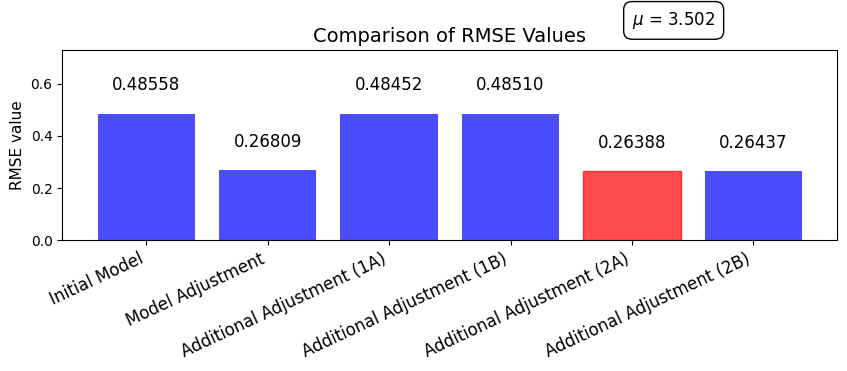

In [59]:
import matplotlib.pyplot as plt

rmse_values = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6]

labels = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1A)",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]

min_rmse_index = rmse_values.index(min(rmse_values))

fig, ax = plt.subplots(figsize=(10, 5))

# Graphique RMSE
bars = ax.bar(labels, rmse_values, color="blue", alpha=0.7)

bars[min_rmse_index].set_color("red")  # Changer la couleur de la barre avec le RMSE minimum


ax.set_xticks(range(len(labels)))  
ax.set_xticklabels(labels, rotation=25, ha="right", fontsize=12)

# Annoter chaque barre avec 4 chiffres après la virgule
for i, v in enumerate(rmse_values):
    ax.text(i, v + 0.09, f"{v:.5f}", ha='center', fontsize=12)

ax.set_ylim(0, max(rmse_values) * 1.5)  # Agrandir l'axe Y de 20 % par rapport à la valeur maximale

# legend
ax.text(4, max(rmse_values) * 1.7, f"$\\mu$ = {mu:.3f}", ha='left', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Titre et labels
ax.set_title("Comparison of RMSE Values",fontsize= 14)
ax.set_ylabel("RMSE value",fontsize= 11)

plt.subplots_adjust(bottom=0.5)
plt.savefig("Image/RMSE_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

#### MAE

In [60]:
mae1 = np.sum(np.abs((predict1 - Y) * R)) / nb_evaluation
mae2 = np.sum(np.abs((predict2 - Y) * R)) / nb_evaluation
mae3 = np.sum(np.abs((predict3 - Y) * R)) / nb_evaluation
mae4 = np.sum(np.abs((predict4 - Y) * R)) / nb_evaluation
mae5 = np.sum(np.abs((predict5 - Y) * R)) / nb_evaluation
mae6 = np.sum(np.abs((predict6 - Y) * R)) / nb_evaluation
print(f"La moyenne de toutes les notes attribuées (globale) : {mu}\n")
print("1.MAE du modèle initial:", mae1)
print("2.MAE de l'ajustement du modèle:", mae2)
print("3.MAE de l'ajustement supplémentaire du modèle (1A):", mae3)
print("4.MAE de l'ajustement supplémentaire du modèle (1B):", mae4)
print("5.MAE de l'ajustement supplémentaire du modèle (2A):", mae5)
print("6.MAE de l'ajustement supplémentaire du modèle (2B):", mae6,"\n")
print(f"La proportion de MAE 1 par rapport à la note moyenne globale.: {(mae1/mu)*100:0.3f} %" )
print(f"La proportion de MAE 2 par rapport à la note moyenne globale.: {(mae2/mu)*100:0.3f} %" )
print(f"La proportion de MAE 3 par rapport à la note moyenne globale.: {(mae3/mu)*100:0.3f} %" )
print(f"La proportion de MAE 4 par rapport à la note moyenne globale.: {(mae4/mu)*100:0.3f} %" )
print(f"La proportion de MAE 4 par rapport à la note moyenne globale.: {(mae5/mu)*100:0.3f} %" )
print(f"La proportion de MAE 6 par rapport à la note moyenne globale.: {(mae6/mu)*100:0.3f} %" )
#dans le but de compararer avec les modeles utilisant PCA
cv_mae5 = (mae5/mu)*100
cv_mae6 = (mae6/mu)*100 

La moyenne de toutes les notes attribuées (globale) : 3.501527080895623

1.MAE du modèle initial: 0.35142142397059095
2.MAE de l'ajustement du modèle: 0.19941009788868597
3.MAE de l'ajustement supplémentaire du modèle (1A): 0.34979641716956295
4.MAE de l'ajustement supplémentaire du modèle (1B): 0.35060191756501546
5.MAE de l'ajustement supplémentaire du modèle (2A): 0.1948493552690919
6.MAE de l'ajustement supplémentaire du modèle (2B): 0.19504590768736438 

La proportion de MAE 1 par rapport à la note moyenne globale.: 10.036 %
La proportion de MAE 2 par rapport à la note moyenne globale.: 5.695 %
La proportion de MAE 3 par rapport à la note moyenne globale.: 9.990 %
La proportion de MAE 4 par rapport à la note moyenne globale.: 10.013 %
La proportion de MAE 4 par rapport à la note moyenne globale.: 5.565 %
La proportion de MAE 6 par rapport à la note moyenne globale.: 5.570 %


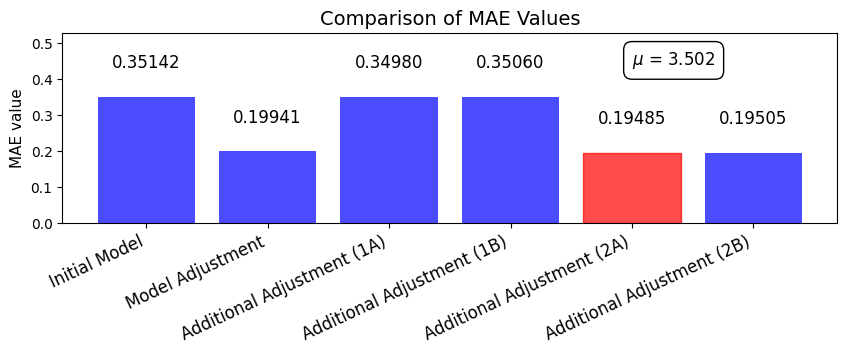

In [61]:
mae_values = [mae1, mae2, mae3, mae4, mae5, mae6]

labels = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1A)",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]

# min MAE
min_mae_index = mae_values.index(min(mae_values))


fig, ax = plt.subplots(figsize=(10, 5))

# Graphiqu
bars = ax.bar(labels, mae_values, color="blue", alpha=0.7)

# Changer la couleur de la barre avec la valeur minimale
bars[min_mae_index].set_color("red")  # Changer la couleur de la barre avec le MAE minimum

# Définir manuellement les positions des ticks
ax.set_xticks(range(len(labels)))  
ax.set_xticklabels(labels, rotation=25, ha="right", fontsize=12)

for i, v in enumerate(mae_values):
    ax.text(i, v + 0.08, f"{v:.5f}", ha='center', fontsize=12)

ax.set_ylim(0, max(mae_values) * 1.5) # Agrandir l'axe Y de 20 % par rapport à la valeur maximale

# legend
ax.text(4, max(mae_values) * 1.25, f"$\\mu$ = {mu:.3f}", ha='left', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


ax.set_title("Comparison of MAE Values",fontsize= 14)
ax.set_ylabel("MAE value",fontsize= 11)

plt.subplots_adjust(bottom=0.5)
plt.savefig("Image/MAE_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

#### Pearson product-moment Correlation Coefficient (PCC)

In [62]:
mask = Y != 0
mu_hat1 = np.mean(predict1[mask])
mu_hat2 = np.mean(predict2[mask])
mu_hat3 = np.mean(predict3[mask])
mu_hat4 = np.mean(predict4[mask])
mu_hat5 = np.mean(predict5[mask])
mu_hat6 = np.mean(predict6[mask])
print(f"La moyenne de Ymean : {np.mean(Ymean)}\n")
print(f"La moyenne de toutes les notes prédites (du modèle initial) : {mu_hat1}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement du modèle) : {mu_hat2}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (1A)) : {mu_hat3}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (1B)) : {mu_hat4}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2A)) : {mu_hat5}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2B)) : {mu_hat6}\n")
print(f"La moyenne de toutes les notes (globale) : {mu}")

La moyenne de Ymean : 3.2624895815718498

La moyenne de toutes les notes prédites (du modèle initial) : 3.5018222384573026
La moyenne de toutes les notes prédites (de l'ajustement du modèle) : 3.50278218814633
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (1A)) : 3.5011873032088294
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (1B)) : 3.50116545125232
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2A)) : 3.501128757411674
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2B)) : 3.501208744101966

La moyenne de toutes les notes (globale) : 3.501527080895623


In [63]:
numerateur1 = ((predict1 - mu_hat1) * (Y - mu) * R).sum()
denominateur1 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict1 - mu_hat1)*R)**2).sum() )
pcc1 = numerateur1/denominateur1
print("PCC du modèle initial: ",pcc1)

numerateur2 = ((predict2 - mu_hat2) * (Y - mu) * R).sum()
denominateur2 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict2 - mu_hat2)*R)**2).sum() )
pcc2 = numerateur2/denominateur2
print("PCC de l'ajustement du modèle: ",pcc2)

numerateur3 = ((predict3 - mu_hat3) * (Y - mu) * R).sum()
denominateur3 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict3 - mu_hat3)*R)**2).sum() )
pcc3 = numerateur3/denominateur3
print("PCC de l'ajustement supplémentaire du modèle (1A): ",pcc3)

numerateur4 = ((predict4 - mu_hat4) * (Y - mu) * R).sum()
denominateur4 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict4 - mu_hat4)*R)**2).sum() )
pcc4 = numerateur4/denominateur4
print("PCC de l'ajustement supplémentaire du modèle (1B): ",pcc4)

numerateur5 = ((predict5 - mu_hat5) * (Y - mu) * R).sum()
denominateur5 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict5 - mu_hat5)*R)**2).sum() )
pcc5 = numerateur5/denominateur5
print("PCC de l'ajustement supplémentaire du modèle (2A): ", pcc5)

numerateur6 = ((predict6 - mu_hat6) * (Y - mu) * R).sum()
denominateur6 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict6 - mu_hat6)*R)**2).sum() )
pcc6 = numerateur6/denominateur6
print("PCC de l'ajustement supplémentaire du modèle (2B): ", pcc6)

PCC du modèle initial:  0.8859230830773038
PCC de l'ajustement du modèle:  0.9726258309886389
PCC de l'ajustement supplémentaire du modèle (1A):  0.8860295402963518
PCC de l'ajustement supplémentaire du modèle (1B):  0.8857427729240349
PCC de l'ajustement supplémentaire du modèle (2A):  0.9720528149385737
PCC de l'ajustement supplémentaire du modèle (2B):  0.9719751683385274


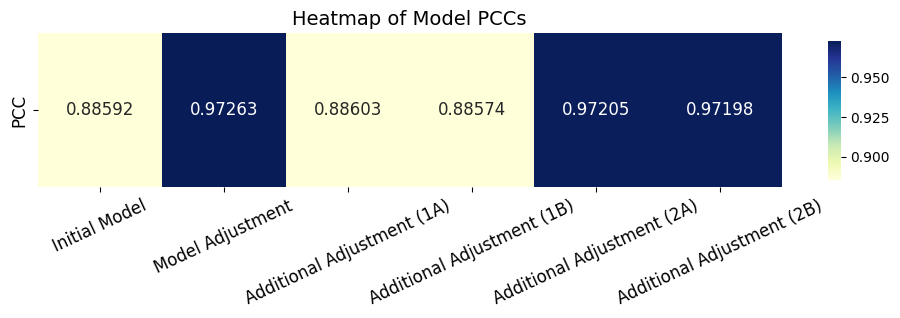

In [64]:
import seaborn as sns

pcc_values = [pcc1, pcc2, pcc3, pcc4, pcc5, pcc6]
matrice_pcc = np.array(pcc_values).reshape(1, -1)

etiquettes = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1A)",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]

# heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(matrice_pcc, annot=True, fmt=".5f", xticklabels=etiquettes, yticklabels=["PCC"], cmap="YlGnBu",annot_kws={"size": 12},cbar_kws={"shrink": 0.9, "aspect": 11})
plt.xticks(rotation=25,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Heatmap of Model PCCs",fontsize =14)
plt.savefig("Image/heatmap_pcc.png", dpi=300, bbox_inches='tight')
plt.show()

In [65]:
import pickle

eva_model = [rmse5, rmse6, mae5, mae6, cv_rmse5,cv_rmse6,cv_mae5,cv_mae6]

# Ouverture d'un fichier en mode écriture binaire pour enregistrer la liste dans un fichier
with open('var1.pkl', 'wb') as f:
    # Sauvegarde de la liste 'eva_model' dans le fichier 'var1.pkl' en utilisant pickle
    pickle.dump(eva_model, f)

## Recommandation. <a id="6"></a>

In [66]:
movie_list, movie_listDf = movies_list()#Importer la liste des films

### Comparaison entre les notes originales et les notes prévisionnelles. <a id="6.1"></a>

**L'ancien utilisateur**

Je choisis l'utilisateur qui a l'ID 3 et l'index 3, car cet utilisateur critique beaucoup de films. C'est le signal de biais utilisateur.

In [67]:
# La variable user renvoie les films notés par l'utilisateur Id 3
user= Y[R[:, 3].astype(bool),3] #Vous pouvez choisir un autre utilisateur en changeant 3 par un autre numéro, nous avons de 0 à 610 utilisateurs.
indices = np.argwhere(R[:, 3].astype(bool))#Les indices des éléments notés par l'utilisateur Id 3.
print(user.shape)# Le nombre de films notés par l'utilisateur Id 3

(39,)


Effectuez la recommandation avec le meilleur modèle : **la deuxième considération (B)**.

In [68]:
print("La matrice approximee de Y \n")
df_p6_moy = pd.DataFrame(predict6)
print(df_p6_moy.head())

La matrice approximee de Y 

        0         1         2         3         4         5         6    \
0  4.747518  4.353182  3.796967  3.067623  2.269912  4.169125  4.347772   
1  3.698441  4.269042  3.776664  2.559274  2.499510  3.374927  4.192737   
2  3.537199  4.336322  3.435007  1.760615  1.702265  3.297498  4.283147   
3  2.456069  3.294065  2.706810  0.949861  1.874446  1.943878  2.913126   
4  3.365812  5.115786  3.707126  1.387867  3.843695  3.142685  4.598544   

        7         8         9    ...       601       602       603       604  \
0  4.308897  3.563893  3.873540  ...  4.179694  4.171283  4.052331  3.317832   
1  3.789003  3.618319  3.564087  ...  3.716650  3.652398  2.681699  4.519759   
2  3.026838  2.948363  3.320457  ...  3.873592  2.859536  2.472417  3.370966   
3  1.717099  2.265070  2.445118  ...  2.748323  2.110012  0.786017  2.625701   
4  3.357166  2.642848  2.662548  ...  3.449132  2.395266  0.682848  3.140897   

        605       606       607       6

In [69]:
for i,y in enumerate(indices): #example
    print(i,y)
    print(y[0])
    if i == 5:
        break

0 [30]
30
1 [461]
461
2 [545]
545
3 [565]
565
4 [585]
585
5 [656]
656


In [70]:
# Boucle sur chaque index dans 'indices' avec un compteur 'i'
for i, y in enumerate(indices):
    idx = y[0]  # Récupère l'index du film à partir de 'y', qui est une liste contenant l'index

    # Récupère la prédiction correspondante à l'index 'idx' dans la colonne 3 de 'p6_moy'
    # 'tf.gather' est utilisé pour extraire des valeurs d'un tenseur basé sur les index fournis
    prédiction = tf.gather(p6moy[:, 3], idx).numpy().item()  # Convertit le tenseur en valeur scalaire

    # Affiche la note originale de l'utilisateur et la prédiction
    # 'user[i]' donne la note réelle de l'utilisateur pour le film, 
    # 'movie_list[idx]' fournit le titre du film correspondant à l'index
    print(f"Original : {user[i]:0.2f}; vs Prédiction : {prédiction:0.3f} pour le film {movie_list[idx]}")

Original : 0.50; vs Prédiction : 0.751 pour le film Dangerous Minds (1995)
Original : 0.50; vs Prédiction : 0.670 pour le film Schindler's List (1993)
Original : 0.50; vs Prédiction : 0.783 pour le film Courage Under Fire (1996)
Original : 0.50; vs Prédiction : 0.714 pour le film Operation Dumbo Drop (1995)
Original : 0.50; vs Prédiction : 0.848 pour le film Wallace & Gromit: The Best of Aardman Animation (1996)
Original : 5.00; vs Prédiction : 4.677 pour le film Escape from L.A. (1996)
Original : 0.50; vs Prédiction : 0.985 pour le film My Fair Lady (1964)
Original : 0.50; vs Prédiction : 0.738 pour le film Basic Instinct (1992)
Original : 0.50; vs Prédiction : 0.623 pour le film Perfect Candidate, A (1996)
Original : 0.50; vs Prédiction : 1.070 pour le film Great Escape, The (1963)
Original : 0.50; vs Prédiction : 0.951 pour le film Fried Green Tomatoes (1991)
Original : 3.50; vs Prédiction : 3.278 pour le film Akira (1988)
Original : 0.50; vs Prédiction : 0.543 pour le film Forbidde

**Le nouvel utilisateur** <a id="rec"></a>

Tout en haut, j'ai déjà créé un [nouvel utilisateur](#new-user). Maintenant, je vais lui faire des recommandations.

In [71]:
print("Les nouvelles évaluations de l'utilisateur:\n")
for i in mes_notations:
        print(f'A attribué la note {mes_notes[i]} pour {movie_list[i]}.')

Les nouvelles évaluations de l'utilisateur:

A attribué la note 5.0 pour Toy Story (1995).
A attribué la note 2.0 pour Terminal Velocity (1994).
A attribué la note 3.0 pour Nightmare Before Christmas, The (1993).
A attribué la note 4.0 pour Madeline (1998).
A attribué la note 2.0 pour Pi (1998).
A attribué la note 5.0 pour Loser (2000).
A attribué la note 4.0 pour Road Trip (2000).
A attribué la note 3.0 pour Benji (1974).
A attribué la note 1.0 pour Hannibal (2001).
A attribué la note 3.0 pour Time After Time (1979).


In [72]:
# La variable user renvoie les films notés par l'utilisateur Id 1 (nouvel utilisateur)
nouvel_utilisateur = Y[R[:, 0].astype(bool),0] 
indices = np.argwhere(R[:, 0].astype(bool))#Les indices des éléments notés par l'utilisateur Id 1.
print(nouvel_utilisateur.shape)# Le nombre de films notés par l'utilisateur Id 1

(10,)


In [73]:
# Boucle pour parcourir chaque index et valeur dans la liste des indices
for i, y in enumerate(indices):
    idx = y[0]  # Récupérer l'index (première valeur de y) pour accéder au bon élément

    # Extraire la prédiction en utilisant tf.gather sur le tenseur p6_moy
    # Cela permet de récupérer la valeur dans la première colonne du tenseur à l'index spécifié
    prédiction = tf.gather(p6moy[:, 0], idx).numpy().item()  # Extraire la valeur scalaire du tenseur

    # Afficher la note originale de l'utilisateur et la prédiction pour le film correspondant
    print(f"Original : {nouvel_utilisateur[i]:0.2f}; vs Prédiction : {prédiction:0.3f} pour le film {movie_list[idx]}")

Original : 5.00; vs Prédiction : 4.748 pour le film Toy Story (1995)
Original : 2.00; vs Prédiction : 2.188 pour le film Terminal Velocity (1994)
Original : 3.00; vs Prédiction : 3.205 pour le film Nightmare Before Christmas, The (1993)
Original : 4.00; vs Prédiction : 3.715 pour le film Madeline (1998)
Original : 2.00; vs Prédiction : 2.304 pour le film Pi (1998)
Original : 5.00; vs Prédiction : 4.726 pour le film Loser (2000)
Original : 4.00; vs Prédiction : 3.780 pour le film Road Trip (2000)
Original : 3.00; vs Prédiction : 3.248 pour le film Benji (1974)
Original : 1.00; vs Prédiction : 1.545 pour le film Hannibal (2001)
Original : 3.00; vs Prédiction : 2.695 pour le film Time After Time (1979)


### Recommandation des films pour le nouvel utilisateur. <a id="6.2"></a>

On veut recommander tous les films avec les notes prévisionnelles très hautes. Dans ce cas, je choisis 4,8 comme norme. Ainsi, tous les films dont la note est supérieure à cela seront recommandés.

In [74]:
condition = predict6[predict6[:, 0] > 4.8, 0]  #predict6 est initialisé dans partie Evaluation
sorted_indices = np.argsort(condition)[::-1] #Sélectionner les indices où les notes vont du plus grand au plus petit
recommandation = condition[sorted_indices]
print(f"Il y a {condition.shape[0]} films qui sont probablement les préférences du nouvel utilisateur.")

Il y a 315 films qui sont probablement les préférences du nouvel utilisateur.


In [75]:
print("Les films que vous pourriez aimer :\n")
for i, y in enumerate(sorted_indices):# Afficher les 10 films les plus favorables
    print(f"La note prévisionnelle : {condition[y]:0.3f} pour le film {movie_list[y]}")
    if i == 9:
        break

Les films que vous pourriez aimer :

La note prévisionnelle : 5.052 pour le film Species (1995)
La note prévisionnelle : 5.034 pour le film Hate (Haine, La) (1995)
La note prévisionnelle : 5.032 pour le film Balto (1995)
La note prévisionnelle : 5.000 pour le film Nick of Time (1995)
La note prévisionnelle : 5.000 pour le film Three Colors: Red (Trois couleurs: Rouge) (1994)
La note prévisionnelle : 5.000 pour le film Forrest Gump (1994)
La note prévisionnelle : 5.000 pour le film Three Colors: Blue (Trois couleurs: Bleu) (1993)
La note prévisionnelle : 5.000 pour le film Mallrats (1995)
La note prévisionnelle : 5.000 pour le film Mighty Morphin Power Rangers: The Movie (1995)
La note prévisionnelle : 5.000 pour le film Clerks (1994)


De plus, on pourrait envisager d'afficher des films qui ont reçu beaucoup d'évaluations. Cela pourrait probablement attirer l'attention des utilisateurs critiques ou exigeants.

In [76]:
# Calcul du nombre de notes pour chaque film
nb_notations_film = np.sum(Y>0, axis=1)
# Trie des indices des films du plus grand nombre de notations au plus petit
indices = np.argsort(nb_notations_film)[::-1]
print(indices)
# Nombre de notations triées du plus grand au plus petit pour chaque film
nb_notes_triees = nb_notations_film[indices]
print(nb_notes_triees)

[ 314  277  257 ... 6653 3010 9723]
[329 317 307 ...   1   1   1]


In [77]:
for z,y in enumerate(indices):
        print(f"{nb_notes_triees[z]} évaluations || une moyenne de {Ymean[y, 0]:0.2f} || {movie_list[y]}")
        if z == 2 :
           break

329 évaluations || une moyenne de 4.16 || Forrest Gump (1994)
317 évaluations || une moyenne de 4.43 || Shawshank Redemption, The (1994)
307 évaluations || une moyenne de 4.20 || Pulp Fiction (1994)


On dispose d'une fonctionnalité supplémentaire pour cette approche : trier d'abord par la moyenne des notes de la plus grande à la plus petite, puis par le nombre d'évaluations.

In [78]:
# Sélection des indices des films ayant au moins 75 notations et triés par moyenne décroissante
indices_tries_par_moyenne = np.where(nb_notations_film > 75)[0]  # Sélection des indices avec au moins 50 notations
indices_tries_par_moyenne = indices_tries_par_moyenne[np.argsort(Ymean[indices_tries_par_moyenne, 0])[::-1]]  # Tri par moyenne décroissante

print("Les films populaires qui pourraient vous intéresser:\n")

# Affichage des informations pour les 5 premiers films triés
for z, y in enumerate(indices_tries_par_moyenne):
    print(f"{nb_notations_film[y]} évaluations || Prédiction {p3moy[y,0]:0.2f} || une moyenne de {Ymean[y, 0]:0.3f} || {movie_list[y]}")
    if z == 9:  
        break

Les films populaires qui pourraient vous intéresser:

317 évaluations || Prédiction 4.49 || une moyenne de 4.429 || Shawshank Redemption, The (1994)
192 évaluations || Prédiction 4.23 || une moyenne de 4.289 || Godfather, The (1972)
218 évaluations || Prédiction 3.95 || une moyenne de 4.273 || Home Alone 2: Lost in New York (1992)
97 évaluations || Prédiction 4.04 || une moyenne de 4.268 || Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
84 évaluations || Prédiction 3.97 || une moyenne de 4.262 || Rear Window (1954)
129 évaluations || Prédiction 4.02 || une moyenne de 4.260 || Blues Brothers, The (1980)
107 évaluations || Prédiction 4.21 || une moyenne de 4.252 || Fear City: A Family-Style Comedy (La cité de la peur) (1994)
126 évaluations || Prédiction 4.23 || une moyenne de 4.250 || Third Man, The (1949)
100 évaluations || Prédiction 4.34 || une moyenne de 4.240 || Casablanca (1942)
149 évaluations || Prédiction 4.21 || une moyenne de 4.238 || 10,000 BC (2

**-----C'est fini-----**

[FAIRE DÉFILER VERS LE HAUT](#0)